# TUM IAPG Observatory sensor analysis

Preliminary analysis of the sensor used in the TUM IAPG observatory. Specific details:

CCD: [FLI CCD Camera](http://www.flicamera.com/microline/index.html) <br>
Telescope: Celestron <br>
Mount: 10micro <br>
Focuser: TCF <br>
**TODO: FILL**

Pictures taken:<br>
Bias: 5 pictures at 0.001s exp (minimum)<br>
Dark: 10 pictures at 5s exp<br>
Flat: 10 pictures at 5s exp

Conclusions of the analysis: pixels `x=[0:150],y=[0:30]` must be cropped out due to the state of the sensor.

## Imports

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import re,os

## Some helper functions

For finding the path and loading.

`pic_path` uses a regular expression and returns the image name provided the root folder, the image folder (Ekos project folder) and the number of the image.

`load_image` uses the path returned by `pic_path` to load the image.

`load_folder` loads all images in the project to an array

In [2]:
def pic_path(root_folder,image_folder,image_number):
    prefix = 'trial_'+image_folder.lower()
    duration = '.*'
    number = image_number
    p=re.compile(prefix+'.*'+image_folder+'.*'+duration+'.*'+number+'\.fits')
    image_path = os.path.join(root_folder,image_folder)

    allfiles = os.listdir(image_path)
    for ifile in allfiles:
        if p.match(ifile):
            image_file = p.match(ifile).group(0)
    return os.path.join(image_path,image_file)

def load_image(image_path):
    hdu_list = fits.open(image_path)
    return hdu_list[0].data

def load_folder(root_folder,image_folder):
    image_path = os.path.join(root_folder,image_folder)
    allfiles = os.listdir(image_path)
    folder_data = []
    for ifile in allfiles:
        folder_data.append(load_image(os.path.join(image_path,ifile)))
    return np.array(folder_data)

def correct_stack(stack,corrector):
    sta_size = stack.shape[0]
    return stack-np.tile(corrector,(sta_size,1,1))
    
def min_threshold(image_orig,level):
    image = np.copy(image_orig)
    idx = image > level
    image[idx] = level
    return image
    
def max_threshold(image_orig,level):
    image = np.copy(image_orig)
    idx = image < level
    image[idx] = level
    return image

Some constants

In [3]:
root_folder = '.'
image_folder = 'Flat'
image_number = '3'

# A first look: pixel analysis

A bias, dark and flat images respectively. It immediately becomes apparent that the flat image has a dark pixel like for low pixel numbers on x and y

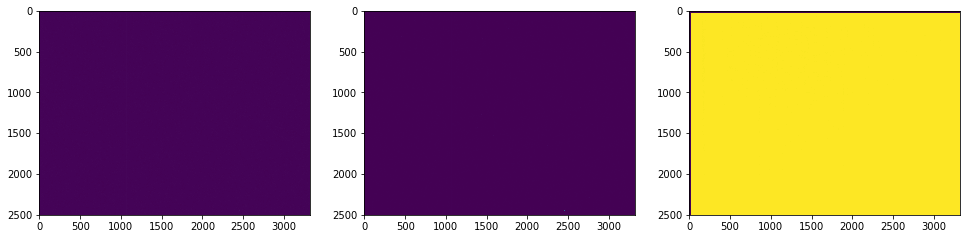

In [4]:
image_path = pic_path(root_folder,'Bias',image_number)
image_dataB = load_image(image_path)
image_path = pic_path(root_folder,'Dark',image_number)
image_dataD = load_image(image_path)
image_path = pic_path(root_folder,'Flat',image_number)
image_dataF = load_image(image_path)
plt.subplot(131)
plt.imshow(image_dataB)
plt.subplot(132)
plt.imshow(image_dataD)
plt.subplot(133)
plt.imshow(image_dataF)
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

### Bias analysis

A look to line `y=100` on the bias image shows the bias for low numbers affected by some thermal noise (left). A series of averaged pictures reduces the noise (right). I would recommend taking many more pictures since the bias is supposed to be a fixed number. Note the lower bias values of low pixel numbers in `x`.

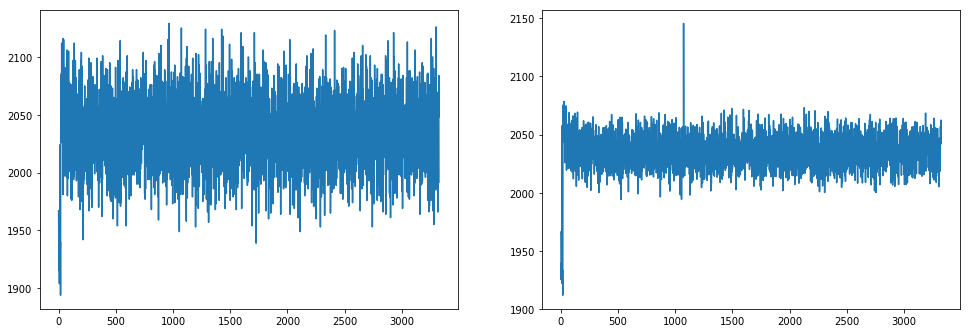

In [5]:
image_path = pic_path(root_folder,'Bias',image_number)

image_data = load_image(image_path)
folder_data = load_folder(root_folder,'Bias')

plt.subplot(121)
plt.plot(image_data[100,:])
plt.subplot(122)
plt.plot(np.mean(folder_data,axis=0)[100,:])
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

### Dark analysis

At first glance the dark images seem similar, although the histogram analysis will later show otherwise.

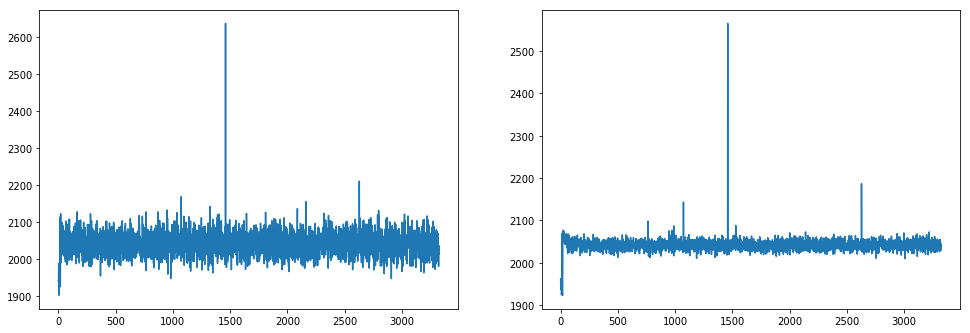

In [6]:
image_path = pic_path(root_folder,'Dark',image_number)

image_data = load_image(image_path)
folder_data = load_folder(root_folder,'Dark')

plt.subplot(121)
plt.plot(image_data[100,:])
plt.subplot(122)
plt.plot(np.mean(folder_data,axis=0)[100,:])
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

### Flat analysis

A first look at the flat immediately showed those lines of dead pixels in the image above. A look at line `y=100` shows clearly that those pixels seem dead or somehow covered.

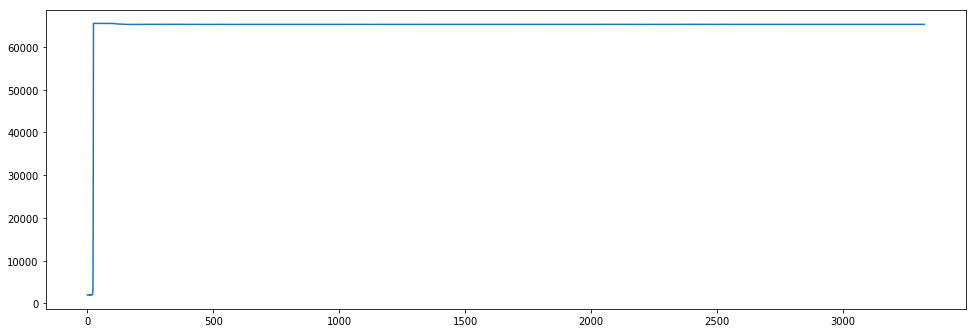

In [7]:
image_path = pic_path(root_folder,'Flat',image_number)

image_data = load_image(image_path)

plt.plot(image_data[100,:])
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

Omitting the first 25 pixels shows again an interesting effect: the pixels immediately after the dead zone seem to be saturated to their maximum value of $2^{16}-1$. The reason as to why this happens is currently unknown.

65535


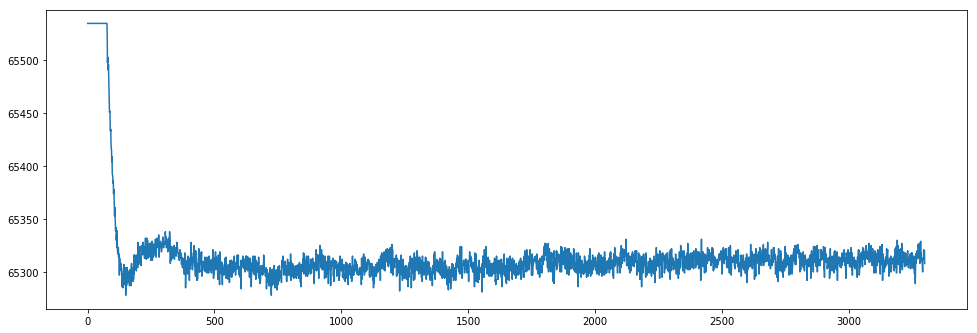

In [8]:
image_path = pic_path(root_folder,'Flat',image_number)

image_data = load_image(image_path)

plt.plot(image_data[100,25:])
print(image_data[100,25])
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

What can be easily seen is that the gradient takes about 100px (left figure). It is recommended that the pictures be cropped to `x=150` onwards (right figure).

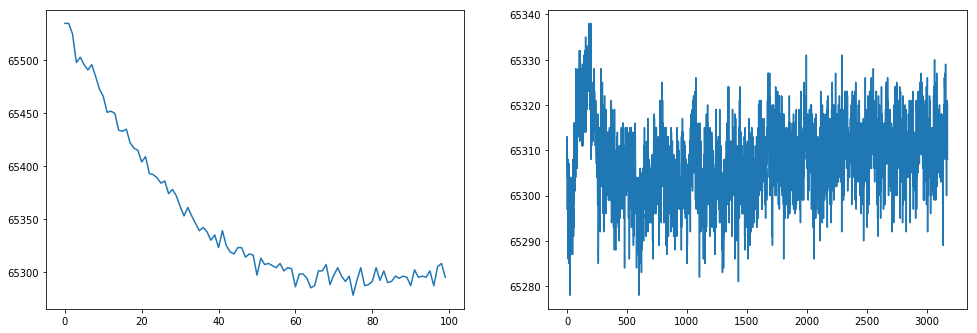

In [9]:
image_path = pic_path(root_folder,'Flat',image_number)

image_data = load_image(image_path)
folder_data = load_folder(root_folder,'Flat')

plt.subplot(121)
plt.plot(image_data[100,100:200])
plt.subplot(122)
plt.plot(image_data[100,150:])
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

A similar analysis along the `y` axis suggests it should be cropped at `y=30`.

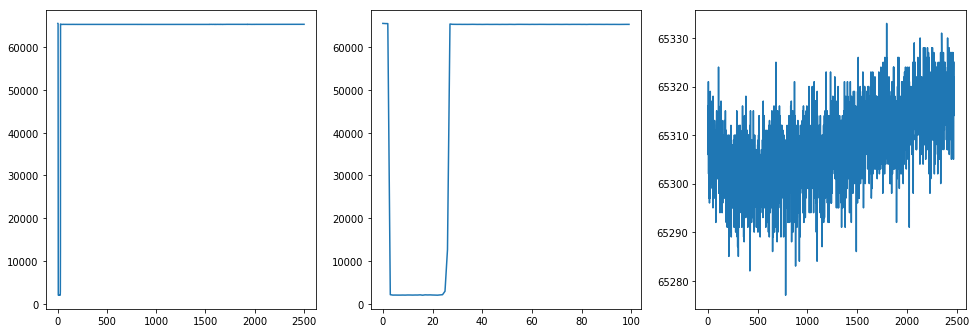

In [10]:
image_path = pic_path(root_folder,'Flat',image_number)
image_data = load_image(image_path)
folder_data = load_folder(root_folder,'Flat')

plt.subplot(131)
plt.plot(image_data[:,500])
plt.subplot(132)
plt.plot(image_data[0:100,500])
plt.subplot(133)
plt.plot(image_data[30:,500])
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()

## Histogram analysis

### Bias histogram

The bias histogram shows a near-Gaussian distribution centered around low values, as expected. A small tail shows the presence of noise due to the non-zero aperture time. A thresholding of `2400` has been applied to show the majority of the pixels. There are some hot pixels far above the threshold.

[1885, 22216]


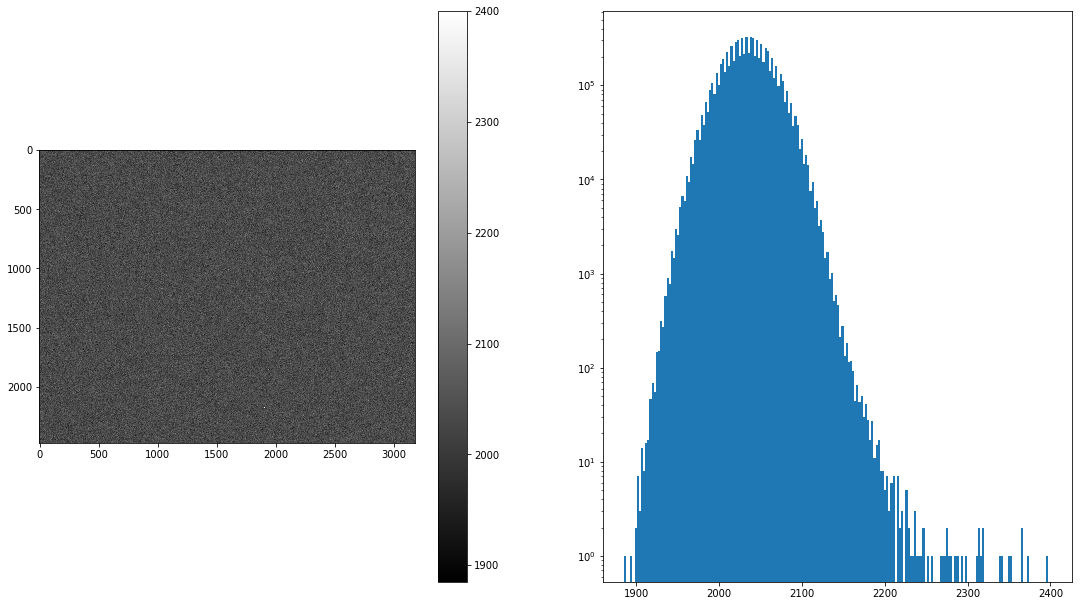

In [11]:
image_path = pic_path(root_folder,'Bias',image_number)
image_data = load_image(image_path)
image_data_crop = image_data[30:,150:]
minval = min(image_data_crop.flatten())
maxval = max(image_data_crop.flatten())
print([minval,maxval])

plt.subplot(121)
plt.imshow(min_threshold(image_data_crop,2400), cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.hist(image_data_crop.flatten(),200,range=(minval,2400),log=True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### Dark histogram

The top histogram is similar to that of the bias, because a longer aperture time is needed and the bias has not been corrected. After the correction (bottom) most counts appear at low brightness, corresponding to darkness.

[1897, 65535]


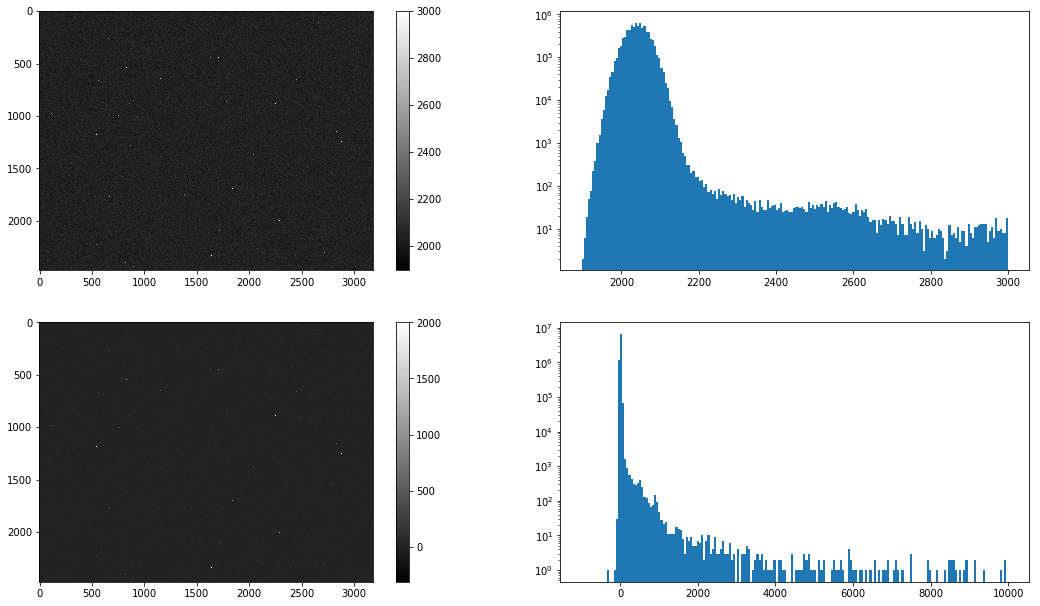

In [12]:
image_path = pic_path(root_folder,'Dark',image_number)
image_data = load_image(image_path)
image_data_crop = image_data[30:,150:]
minval = min(image_data_crop.flatten())
maxval = max(image_data_crop.flatten())
print([minval,maxval])

plt.subplot(221)
plt.imshow(min_threshold(image_data_crop,3000), cmap='gray')
plt.colorbar()
plt.subplot(222)
plt.hist(image_data_crop.flatten(),200,range=(minval,3000),log=True)


correct_bias = np.mean(load_folder(root_folder,'Bias'),axis=0)
correct_dark = np.mean(correct_stack(load_folder(root_folder,'Dark'),correct_bias),axis=0)

plt.subplot(223)
plt.imshow(min_threshold(correct_dark[30:,150:],2000), cmap='gray')
plt.colorbar()
plt.subplot(224)
plt.hist(correct_dark[30:,150:].flatten(),200,range=(-1000,10000),log=True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()


### Flat histogram

The flat histogram shows a Gaussian high-count at large values, and there is the presence of vertical lines and irregularities in the exposure.

[65252, 65367]


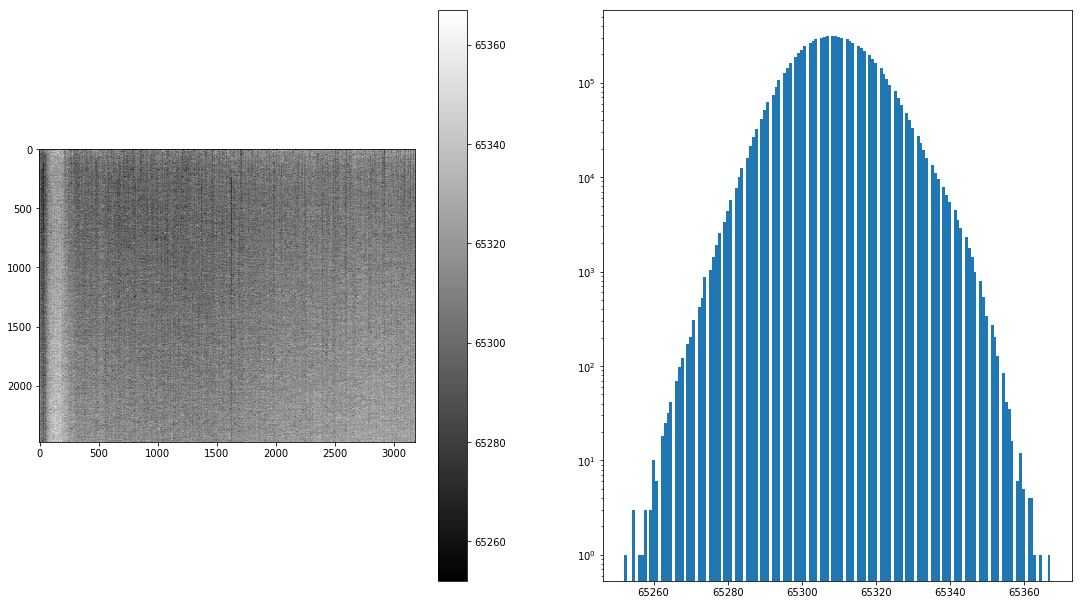

In [13]:
image_path = pic_path(root_folder,'Flat',image_number)
image_data = load_image(image_path)
image_data_crop = image_data[30:,150:]
minval = min(image_data_crop.flatten())
maxval = max(image_data_crop.flatten())
print([minval,maxval])

plt.subplot(121)
plt.imshow(image_data_crop, cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.hist(image_data_crop.flatten(),150,range=(minval,maxval),log=True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

The bias and dark corrections eliminate the problems, showing a much more uniform distribution of the pixels. Further averaging of the 10 flat field images show a histogram with high pixel values without Gaussian character. Thresholding on the image reveals there is still a slight bias along the vertical at pixels 0 to 500. The figure is the averaged version.

[4362.299999999997, 65626.50000000001]


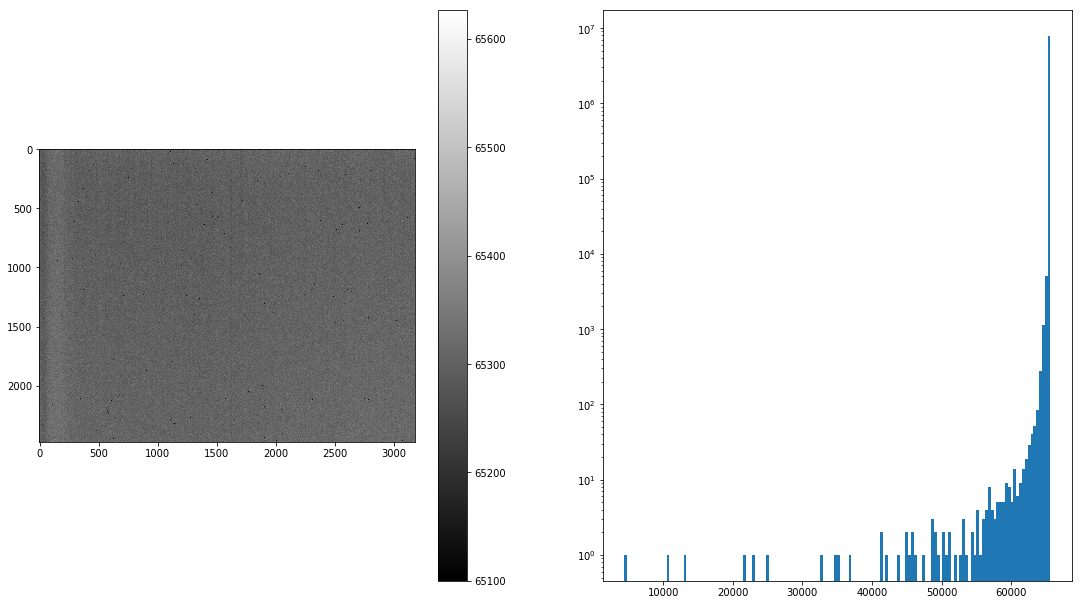

In [14]:
folder_flat = load_folder(root_folder,'Flat')
correct_bias = np.mean(load_folder(root_folder,'Bias'),axis=0)
correct_dark = np.mean(correct_stack(load_folder(root_folder,'Dark'),correct_bias),axis=0)
image_data =  np.mean(correct_stack(folder_flat,correct_dark),axis=0)
image_data_crop = image_data[30:,150:]
minval = min(image_data_crop.flatten())
maxval = max(image_data_crop.flatten())
print([minval,maxval])

plt.subplot(121)
plt.imshow(max_threshold(image_data_crop,65100), cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.hist(image_data_crop.flatten(),150,range=(minval,maxval),log=True,cumulative=False)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

A closer look confirms the bias. The noise level is quite low at $\sigma=50$ or $0.076\%$ of the total range.

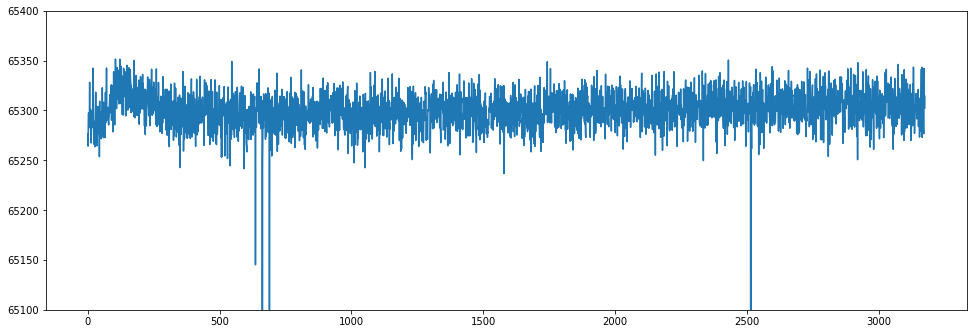

49.32764610978945


In [15]:
plt.plot(image_data_crop[1000,:])
plt.ylim((65100,65400))
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.show()
print(np.std(image_data_crop[1000,:]))